### 非线性偏微分方程的数据驱动解

--------Data-driven Solutions of Nonlinear Partial Differential Equations

在这篇分为两部分的论文的[第一部分](https://arxiv.org/abs/1711.10561)中，我们将重点讨论计算**一般形式偏微分方程**(partial differential equations of the general form)的数据驱动解
$$
\large u_t + \cal N[u] = 0, x\in Ω, t \in [0,T],
$$
其中 $u(t,x)$ 表示潜在（隐藏）解，$\cal N[⋅]$ 是一个**非线性微分算子**(nonlinear differential operator)，$Ω$ 是 $R^D$ 的子集。接下来，我们提出了两类不同的算法，即**连续时间模型和离散时间模型**(continuous and discrete time models)，并通过不同的基准问题来突出它们的性质和性能。[这里](https://github.com/maziarraissi/PINNs)提供了所有代码和数据集。

#### 连续时间模型

--------Continuous Time Models

我们定义 $f(t,x)$ 为
$$
\large f := u_t + \cal N[u],
$$

然后用深度神经网络逼近 $u(t,x)$ 。这个假设产生了一个[物理信息神经网络](https://arxiv.org/abs/1711.10561) $f(t,x)$ 。这个网络可以通过计算图上的演算得到：[反向传播](http://colah.github.io/posts/2015-08-Backprop/)。

##### 示例1(Burgers方程)

作为一个例子，让我们考虑[Burgers方程](https://en.wikipedia.org/wiki/Burgers'_equation)。在一维空间中，Burger方程的Dirichlet边界条件如下
$$
\begin{align}
& \large u_t + uu_x - (0.01/\pi)u_{xx} = 0, x \in [-1,1], t \in [0,1],\\
& \large u(0,x) = -sin(\pi x),\\
& \large u(t,-1) = u(t,1) = 0.\\
\end{align}
$$



让我们定义 $f(t,x)$ 为
$$
\large f := u_t + uu_x - (0.01/\pi)u_{xx},
$$

然后用深度神经网络逼近 $u(t,x)$ 。为了强调这个想法的简单性，让我们用Python来实现它，只需要一点点[Tensorflow](https://www.tensorflow.org/)。为此， $u(t,x)$ 可以简单地定义为

```python
def u(t, x):
    u = neural_net(tf.concat([t,x],1), weights, biases)
    return u
```

相应地，[物理信息神经网络](https://arxiv.org/abs/1711.10561)$f(t,x)$ 采用以下形式

```python
def f(t, x):
    u = u(t, x)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u*u_x - (0.01/tf.pi)*u_xx
    return f
```

通过最小化均方误差损失，可以学习神经网络 $u(t,x)$ 和 $f(t,x)$ 之间的共享参数
$$
\begin{align}
& MSE = MSE_u + MSF_f,\\
& MSE_u = \frac 1 {N_u} \sum^{N_u}_{i=1} |u(t^i_u, x^i_u) - u^i|^2,\\
& MSE_f = \frac 1 {N_f} \sum^{N_f}_{i=1} |f(t^i_f, x^i_f)|^2.\\
\end{align}
$$
这里，$\{ {t^i_u, x^i_u, u^i} \}^{N_u}_{i=1}$ 表示 $u(t,x)$ 上的初始和边界训练数据，$\{{t^i_f,x^i_f}\}^{N_f}_{i=1}$指定 $f(t,x)$ 的配置点。损失 $MSE_u$ 对应于初始和边界数据，而 $MSE_f$ 在有限的配置点集上强制执行Burgers方程施加的结构。

In [ ]:
# !pip install pyDOE

参考代码： ---

In [1]:
import sys
# sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)

In [11]:
torch.__version__

'1.10.1'

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#### Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

#### Configurations

In [5]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

#### Train

In [6]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

In [7]:
%%time
               
model.train()

Iter 100, Loss: 9.29035e-02, Loss_u: 6.07754e-02, Loss_f: 3.21281e-02
Iter 200, Loss: 5.62758e-02, Loss_u: 4.10913e-02, Loss_f: 1.51845e-02
Iter 300, Loss: 3.25851e-02, Loss_u: 2.19337e-02, Loss_f: 1.06513e-02
Iter 400, Loss: 1.76453e-02, Loss_u: 9.66416e-03, Loss_f: 7.98113e-03
Iter 500, Loss: 7.40109e-03, Loss_u: 3.70301e-03, Loss_f: 3.69808e-03
Iter 600, Loss: 3.06777e-03, Loss_u: 1.36563e-03, Loss_f: 1.70213e-03
Iter 700, Loss: 1.54545e-03, Loss_u: 5.64569e-04, Loss_f: 9.80878e-04
Iter 800, Loss: 8.33278e-04, Loss_u: 2.62620e-04, Loss_f: 5.70658e-04
Iter 900, Loss: 5.86433e-04, Loss_u: 1.65065e-04, Loss_f: 4.21368e-04
Iter 1000, Loss: 4.34520e-04, Loss_u: 1.22842e-04, Loss_f: 3.11678e-04
Iter 1100, Loss: 3.14403e-04, Loss_u: 1.01526e-04, Loss_f: 2.12876e-04
Iter 1200, Loss: 2.46424e-04, Loss_u: 7.95268e-05, Loss_f: 1.66897e-04
Iter 1300, Loss: 2.07988e-04, Loss_u: 6.36699e-05, Loss_f: 1.44318e-04
Iter 1400, Loss: 1.72997e-04, Loss_u: 4.26886e-05, Loss_f: 1.30308e-04
Iter 1500, Loss

In [8]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 1.350107e-02


#### Visualizations

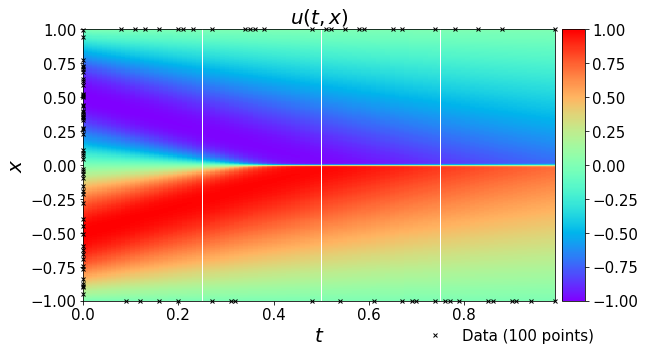

In [9]:
""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

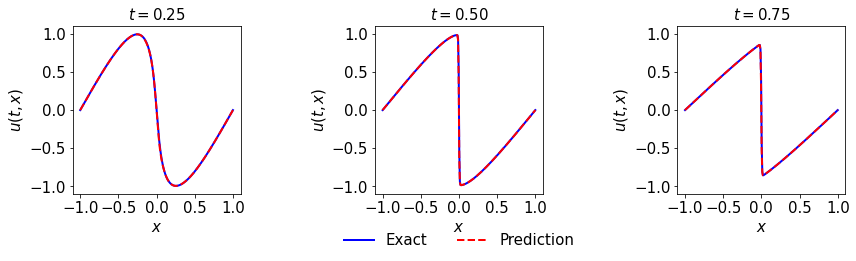

In [10]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

#### 原文结果

下图总结了我们对Burgers方程的数据驱动解决方案的结果。

![img](https://maziarraissi.github.io/assets/img/Burgers_CT_inference.png)



> *Burgers方程*：**顶部**：预测解以及初始和边界训练数据。此外，我们使用10000个搭配点，这些搭配点是使用**拉丁超立方体采样策略**( Latin Hypercube Sampling strategy)生成的。**底部**：与顶部面板中白色垂直线描绘的三个时间快照相对应的预测解和精确解的比较。在一张NVIDIA Titan X GPU卡上进行模型培训大约需要60秒。

------